# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
  
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import BaggingClassifier

from sklearn.ensemble import RandomForestClassifier

# Importing Data.

In [2]:
train_ds = pd.read_csv("./Dataset/train.csv")
test_ds = pd.read_csv("./Dataset/test.csv")

In [3]:
print("Train data shape: {}\nTest data shape: {}".format(train_ds.shape, test_ds.shape))

Train data shape: (891, 12)
Test data shape: (418, 11)


In [4]:
y = train_ds.pop('Survived')
data = train_ds.copy()

# Data Preprocessing and Exploration

- SibSp: # of sibling/spouses aboard the Titanic
- Parch: # of parents/childred aboard the Titanic
- embarked: port of embarkataion (Boarding port of passengers)
    - C = Cherbourg
    - Q = Queenstown
    - S = Southampton
- Pclass: Socio-economic status
    - 1st = Upper
    - 2nd = middle
    - 3rd = lower
- SibSp: Sibling/Spouse(brother, sister, stepbrother, stepsister / husband, wife)
- parch: parent(mother, fatehr), child(daughter, son, stepdaughter, stepson)
- rest are self explanatory

In [5]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
data.describe(include = 'O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Gheorgheff, Mr. Stanio",male,347082,B96 B98,S
freq,1,577,7,4,644


## Dealing with missing value

In [8]:
data.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
data.Age.describe()
# since the mean age and median(or second quartile) are close to each other,
# so the missing values can be replaced by median value

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [10]:
data.Cabin.describe()
# The missing value in case of Cabin are very large so we'll convert the value into true and false
# depending upon whether the person has cabin or not.

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

In [11]:
data.Embarked.describe()
# The missing value in Embarked will be replaced by model of Embarked i.e S

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [12]:
data['Age'].fillna(data.Age.median(), inplace = True)
data['Embarked'].fillna('S', inplace = True)
data['Cabin'] = data['Cabin'].notnull().replace({True:1, False:0})

data.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Feature Engineering
### we have the following Numerical Variables:
- PassengerId: We are going to drop it
- Name: Extract the title and drop names
- Age: Convert into categorical column using bins
- Ticket: drop it
- Fare: convert into categorical variable

### New Features
- The first feature that we are going to create is the title of names which will tell us their position in real life.
- The second and third feature will be the age category and fare category

### Name Title

In [13]:
data['name_title'] = data['Name'].apply(lambda x : x.split(".")[0].split(",")[1].strip())
data['name_title'].unique() 

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [14]:
data['name_title'] = data['name_title'].replace('Mlle','Miss')
data['name_title'] = data['name_title'].replace('Mme','Mrs')
s = ( 'Major', 'Lady', 'Sir','the Countess', 'Jonkheer', 'Don', 'Rev', 'Dr','Capt','Col')
data['name_title'] =  data['name_title'].replace(s,'special')

data.name_title.value_counts()

Mr         517
Miss       184
Mrs        126
Master      40
special     23
Ms           1
Name: name_title, dtype: int64

### Age category

In [15]:
len(data.Age.value_counts())

88

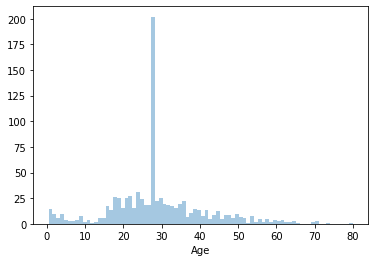

In [16]:
sns.distplot(data.Age, bins =80, kde = False)

### Fare category

In [17]:
data['Age_category'] = pd.qcut(data['Age'], q=4, labels = False)
data.Age_category.value_counts()

1    308
0    231
3    217
2    135
Name: Age_category, dtype: int64

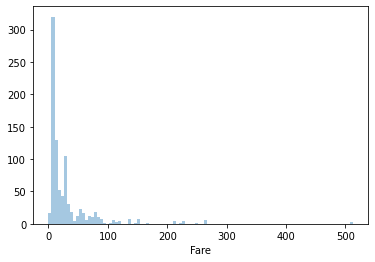

In [18]:
sns.distplot(data.Fare, bins =100, kde = False)

In [19]:
data['Fare_category'] = pd.qcut(data['Fare'], q=4, labels = False)
data.Fare_category.value_counts()

1    224
0    223
3    222
2    222
Name: Fare_category, dtype: int64

# Data visualization

#### Categorical Variable

- Sruvived: THE TARGET
- Pclass
- Sex
- Embarked
- SibSp
- Parch
- Cabin

#### Engineered categorical variables
- name_title
- Age
- Fare

# Some stats
### Gender vs survived

In [20]:
gender_stats = pd.crosstab(index = data.Sex,
                          columns = 'count',
                          normalize = True)
gender_stats
# Out of total passengers 65% were male wheseas only 35% are female

col_0,count
Sex,
female,0.352413
male,0.647587


In [21]:
gender_survivor_stats = pd.crosstab(index = data.Sex,
                                   columns = y,
                                   margins = True,
                                   normalize = 'index')
gender_survivor_stats
# The data below shows that 61% of people onboard Titanic did not survive the crash and only 39% survived
# also 74% of female survives the crash and only 26% died there
# and 81% of male died there wile only 19% survives the crash

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908
All,0.616162,0.383838


### Pclass vs survived

In [22]:
pclasses = pd.crosstab(index = data.Pclass,
                      columns = 'count',
                      normalize = True)
pclasses
# Of the total passengers 55% are 3rd class, 21% are 2nd class, 24% are 1st class passengers.

col_0,count
Pclass,
1,0.242424
2,0.206510
3,0.551066


In [23]:
pclass_survivor_stats = pd.crosstab(index = data.Pclass,
                                   columns = y,
                                   normalize = 'index',
                                   margins = True)
pclass_survivor_stats
# we already know the last line of the data shown below
# among 1st class passengers 63% survives the crash and only 37% died
# for 2nd class passengers the survival is 50-50
# and for 3rd class passengers about 76% died while only 24% survives the crash

Survived,0,1
Pclass,,
1,0.370370,0.629630
2,0.527174,0.472826
3,0.757637,0.242363
All,0.616162,0.383838


### Embarcation vs survived

In [24]:
embarkations = pd.crosstab(index = data.Embarked,
                      columns = 'count',
                      normalize = True)
embarkations
# most of the passengers (73.5%) are from Southampton and least number of passengers(8.6%) are from Queenstown
# Cherbourg falls in between them(18.8%).

col_0,count
Embarked,
C,0.188552
Q,0.086420
S,0.725028


In [25]:
embarkation_survivor_stats = pd.crosstab(index = data.Embarked,
                                   columns = y,
                                   normalize = 'index',
                                   margins = True)
embarkation_survivor_stats

Survived,0,1
Embarked,,
C,0.446429,0.553571
Q,0.610390,0.389610
S,0.660991,0.339009
All,0.616162,0.383838


### sibsp vs survived

In [26]:
SibSps = pd.crosstab(index = data.SibSp,
                      columns = 'count',
                      )
SibSps
# There are more number of passengers with 0 or 1 sibling/spouse with them

col_0,count
SibSp,
0,608
1,209
2,28
3,16
4,18
5,5
8,7


In [27]:
sibsp_survivor_stats = pd.crosstab(index = data.SibSp,
                                   columns = y,
                                   normalize = 'index',)
sibsp_survivor_stats

Survived,0,1
SibSp,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,0.000000
8,1.000000,0.000000


### parch vs survived

In [28]:
parches = pd.crosstab(index = data.Parch,
                      columns = 'count',
                      normalize = True)
parches
# most of passengers are with 0 or 1 or 2 parents

col_0,count
Parch,
0,0.760943
1,0.132435
2,0.089787
3,0.005612
4,0.004489
5,0.005612
6,0.001122


In [29]:
parch_survivor_stats = pd.crosstab(index = data.Parch,
                                   columns = y,
                                   normalize = 'index',
                                   margins = True)
parch_survivor_stats

Survived,0,1
Parch,,
0,0.656342,0.343658
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,0.000000
5,0.800000,0.200000
6,1.000000,0.000000
All,0.616162,0.383838


### cabin vs survived

In [30]:
cabins = pd.crosstab(index = data.Cabin,
                      columns = 'count',
                      normalize = True)
cabins

col_0,count
Cabin,
0,0.771044
1,0.228956


In [31]:
cabin_survivor_stats = pd.crosstab(index = data.Cabin,
                                   columns = y,
                                   normalize = 'index',)
cabin_survivor_stats

Survived,0,1
Cabin,,
0,0.700146,0.299854
1,0.333333,0.666667


### name_title vs survived

In [32]:
name_title_survivor_stats = pd.crosstab(index = data.name_title,
                                   columns = y,
                                   normalize = 'index',)
name_title_survivor_stats

Survived,0,1
name_title,,
Master,0.425000,0.575000
Miss,0.298913,0.701087
Mr,0.843327,0.156673
Mrs,0.206349,0.793651
Ms,0.000000,1.000000
special,0.652174,0.347826


### age_category vs survived

In [33]:
age_category_survivor_stats = pd.crosstab(index = data.Age_category,
                                   columns = y,
                                   normalize = 'index',)
age_category_survivor_stats

Survived,0,1
Age_category,,
0,0.575758,0.424242
1,0.668831,0.331169
2,0.562963,0.437037
3,0.617512,0.382488


### fare_category vs survived

In [34]:
fare_category_survivor_stats = pd.crosstab(index = data.Fare_category,
                                           columns = y,
                                           normalize = 'index',)
fare_category_survivor_stats

Survived,0,1
Fare_category,,
0,0.802691,0.197309
1,0.696429,0.303571
2,0.545045,0.454955
3,0.418919,0.581081


# Applying same data preprocesisng to test dataset

In [35]:
test_ds.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [36]:
test_ds['Age'].fillna(data.Age.median(), inplace = True)
# data['Embarked'].fillna('S', inplace = True)
test_ds['Cabin'] = data['Cabin'].notnull().replace({True:1, False:0})

test_ds['name_title'] = test_ds['Name'].apply(lambda x : x.split(".")[0].split(",")[1].strip())

test_ds['name_title'] = test_ds['name_title'].replace('Mlle','Miss')
test_ds['name_title'] = test_ds['name_title'].replace('Mme','Mrs')
s = ( 'Major', 'Lady', 'Sir','the Countess', 'Jonkheer', 'Don', 'Rev', 'Dr','Capt','Col')
test_ds['name_title'] =  test_ds['name_title'].replace(s,'special')

test_ds['Age_category'] = pd.qcut(test_ds['Age'], q=4, labels = False)

test_ds['Fare_category'] = pd.qcut(test_ds['Fare'], q=4, labels = False)



In [37]:
print(data.shape,test_ds.shape)

(891, 14) (418, 14)


### Removing useless columns

In [38]:
data = data.drop(['Name', 'Ticket','PassengerId','Age', 'Fare'], axis=1)
test_ds = test_ds.drop(['Name', 'Ticket','PassengerId','Age', 'Fare'], axis=1)

In [39]:
data.head()

,Pclass,Sex,SibSp,Parch,Cabin,Embarked,name_title,Age_category,Fare_category
0,3,male,1,0,0,S,Mr,0,0
1,1,female,1,0,1,C,Mrs,3,3
2,3,female,0,0,0,S,Miss,1,1
3,1,female,1,0,1,S,Mrs,2,3
4,3,male,0,0,0,S,Mr,2,1


## converting data into dummy variable

In [40]:
data = pd.get_dummies(data, columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'name_title', 'Age_category','Fare_category'])
test_ds = pd.get_dummies(test_ds, columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'name_title', 'Age_category','Fare_category'])
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 38 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Pclass_1            891 non-null    uint8
 1   Pclass_2            891 non-null    uint8
 2   Pclass_3            891 non-null    uint8
 3   Sex_female          891 non-null    uint8
 4   Sex_male            891 non-null    uint8
 5   SibSp_0             891 non-null    uint8
 6   SibSp_1             891 non-null    uint8
 7   SibSp_2             891 non-null    uint8
 8   SibSp_3             891 non-null    uint8
 9   SibSp_4             891 non-null    uint8
 10  SibSp_5             891 non-null    uint8
 11  SibSp_8             891 non-null    uint8
 12  Parch_0             891 non-null    uint8
 13  Parch_1             891 non-null    uint8
 14  Parch_2             891 non-null    uint8
 15  Parch_3             891 non-null    uint8
 16  Parch_4             891 non-null    uint8
 1

(891, 38)

# Splitting dataset

In [41]:
x_train = data[0 : 800]
y_train = y[0 : 800]

x_val = data[800 : 891]
y_val = y[800 : 891]

In [42]:
# x_train, x_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 21)

In [43]:
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(800, 38) (800,) (91, 38) (91,)


# Creating model
## Logistic regression

In [44]:
logistic = LogisticRegression()

In [45]:
logistic.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [46]:
predictions = logistic.predict(x_val)

In [47]:
# confusion matrix
confusion_matrix = confusion_matrix(y_val, predictions)
confusion_matrix

array([[49,  8],
       [ 5, 29]])

In [48]:
acc = accuracy_score(y_val, predictions)
acc

0.8571428571428571

## Random Forest Classifier

In [49]:
randomforest = RandomForestClassifier(n_estimators = 100)

In [50]:
randomforest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [51]:
y_pred_rf = randomforest.predict(x_val)

In [52]:
acc = accuracy_score(y_val, y_pred_rf)
acc

0.8461538461538461

In [53]:
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88        57
           1       0.81      0.76      0.79        34

    accuracy                           0.85        91
   macro avg       0.84      0.83      0.83        91
weighted avg       0.85      0.85      0.85        91



[0.0227269  0.02417633 0.05777646 0.12923158 0.07985426 0.02506636
 0.02958254 0.00727047 0.01067617 0.00582079 0.0017372  0.00187115
 0.02373573 0.01460326 0.01660169 0.00105698 0.00305755 0.00202689
 0.0007089  0.03199499 0.0344383  0.0239902  0.0121968  0.0271496
 0.01396063 0.0324288  0.13141074 0.03668829 0.00060928 0.00712333
 0.02214782 0.02936546 0.02203149 0.02386789 0.01651253 0.02490892
 0.02533625 0.02625744]
----------------------------------------


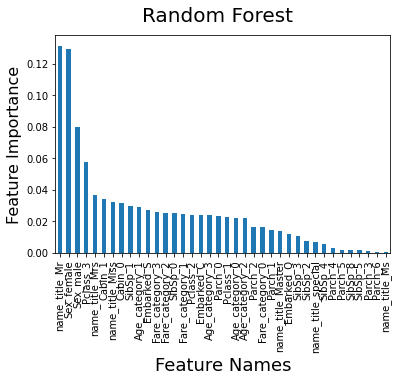

In [54]:
print(randomforest.feature_importances_)

print("-"*40)

col_names = list(x_val.columns)
featur_imp = pd.Series(randomforest.feature_importances_, col_names).sort_values(ascending = False)
featur_imp.plot(kind = 'bar')
plt.suptitle('Random Forest', fontsize=20)
plt.xlabel('Feature Names', fontsize=18)
plt.ylabel('Feature Importance', fontsize=16)
plt.show()